<a href="https://colab.research.google.com/github/canmike/lulc_semantic_segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 7.6 MB/s eta 0:00:00


# 1. Downloading .py Files

In [2]:
import requests
from pathlib import Path

def download_py(file_name:str, path:str=None):
  if path == None:
    path = "https://raw.githubusercontent.com/canmike/lulc_semantic_segmentation/main/" + file_name

  if Path(file_name).is_file():
    print(f"{file_name} already exists, skipping download")
  else:
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get(path)
    with open(file_name, "wb") as f:
      f.write(request.content)
    print(f"Downloaded {file_name}.")

In [3]:
download_py("utils.py")
download_py("visualization.py")
download_py("training.py")
download_py("dataset.py")

Downloaded utils.py.
Downloaded visualization.py.
Downloaded training.py.
Downloaded dataset.py.


# 2. Downloading Data

In [4]:
# import gdown

# id = "1Hf6Zz4MhL_X8bxNvGD7KOX4tlp2fcphj"
# gdown.download_folder(id=id, quiet=True, use_cookies=False)

# import zipfile
# from pathlib import Path
# import os

# data_path = Path("C2Seg_AB/")
# image_path = Path("data")

# with zipfile.ZipFile(data_path / "C2Seg_AB.zip", "r") as zip_ref:
#     print("Unzipping C2Seg_AB data...")
#     zip_ref.extractall(image_path)

# # Remove zip file
# os.remove(data_path / "C2Seg_AB.zip")

In [5]:
# import gdown

# id = "1FhV4kfQtyVj7Ni6cXYOv2PU67aGZK1gP"
# gdown.download_folder(id=id, quiet=True, use_cookies=False)

# import zipfile
# from pathlib import Path
# import os

# data_path = Path("C2Seg_BW")
# image_path = Path("data")

# with zipfile.ZipFile(data_path / "C2Seg_BW_train_msisar.zip", "r") as zip_ref:
#     print("Unzipping C2Seg_BW_train_msisar data...")
#     zip_ref.extractall(image_path)

# # Remove zip file
# os.remove(data_path / "C2Seg_BW_train_msisar.zip")

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import zipfile
from pathlib import Path
import os
data_path = Path("/content/drive/MyDrive/WHISPERS/data")
new_path = Path("data")
with zipfile.ZipFile(data_path / "C2Seg_AB_splitted.zip", "r") as zip_ref:
    print("Unzipping C2Seg_AB data...")
    zip_ref.extractall(new_path)

Unzipping C2Seg_AB data...


In [8]:
data_path = Path("/content/drive/MyDrive/WHISPERS/data")
new_path = Path("data")
with zipfile.ZipFile(data_path / "C2Seg_BW_splitted.zip", "r") as zip_ref:
    print("Unzipping C2Seg_BW data...")
    zip_ref.extractall(new_path)

Unzipping C2Seg_BW data...


# 3. Setting Models

In [9]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

In [10]:
use_msi=True # 4
use_sar=True # 2
use_hsi=False # ...
reduce_hsi=False
reduce_bands=20

in_channels = 0
if use_msi:
  in_channels += 4
if use_sar:
  in_channels += 2
if use_hsi:
  if reduce_hsi:
    in_channels += reduce_bands
  else:
    in_channels += 248

in_channels

6

In [11]:
!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=848b237836c355773ebacc8e1f5f3cd65846578e836f0c0268735ab1fe7900df
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=7ddae7784ad8bed52d8bce075a587c88a1108dd93fbc9b0842427c7c26df9485
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

## 3.1 Setting up device agnostic code

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 4. Defining color-labels

In [13]:
import numpy as np
label_map = np.array([
      (0, 0, 0),          # 0 - Background (Black)
      (0, 0, 255),        # 1 - Surface water (Blue)
      (135, 206, 250),    # 2 - Street (Light Sky Blue)
      (255, 255, 0),      # 3 - Urban Fabric (Yellow)
      (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
      (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
      (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
      (255, 165, 0),      # 7 - Arable Land (Orange)
      (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
      (154, 205, 50),     # 9 - Pastures (Yellow Green)
      (34, 139, 34),      # 10 - Forests (Forest Green)
      (139, 69, 19),      # 11 - Shrub (Saddle Brown)
      (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
      (0, 255, 255),      # 13 - Inland wetlands (Cyan)
  ])


labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

# 5. Training Model

## 5.1 Splitting Train and Validation Data

In [14]:
def get_data_count(filepath="data/C2Seg_AB_splitted/train/msi"):
  files = os.listdir(filepath)
  # files = sorted(files, key=lambda x: int(x.split(".")[0]))
  return len(files)

In [15]:
get_data_count(filepath="data/C2Seg_BW_splitted/train/msi")

19992

In [16]:
# data_count_ab = 191
# #data_count_bw = 7139
# data_count_bw = 7139*4

## 5.2 Creating DataLoaders

In [17]:
batch_size=32

In [18]:
from dataset import SegmentationDataSet
from torch.utils import data
training_dataset_ab = SegmentationDataSet(indexes=list(range(get_data_count(filepath="data/C2Seg_AB_splitted/train/msi"))),
                                       file_path= "/content/data/C2Seg_AB_splitted/train",
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

training_dataloader_ab = data.DataLoader(dataset=training_dataset_ab,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(training_dataloader_ab))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -31.58401107788086; max: 7302.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [19]:
x = (x + x.min())
x = x / x.max()

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}; mean: {x.mean()}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -0.008688364177942276; max: 1.0; mean: 0.11298386007547379


In [20]:
val_dataset_ab = SegmentationDataSet(indexes=list(range(get_data_count(filepath="data/C2Seg_AB_splitted/val/msi"))),
                                       file_path= "/content/data/C2Seg_AB_splitted/train",
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

val_dataloader_ab = data.DataLoader(dataset=val_dataset_ab,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(val_dataloader_ab))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -32.6815185546875; max: 5541.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [24]:
training_dataset_bw = SegmentationDataSet(indexes=list(range(get_data_count(filepath="data/C2Seg_BW_splitted/train/msi"))),
                                       file_path= "/content/data/C2Seg_BW_splitted/train",
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

training_dataloader_bw = data.DataLoader(dataset=training_dataset_bw,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(training_dataloader_bw))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -407.0; max: 15838.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [25]:
val_dataset_bw = SegmentationDataSet(indexes=list(range(get_data_count(filepath="data/C2Seg_BW_splitted/val/msi"))),
                                       file_path= "/content/data/C2Seg_BW_splitted/val",
                                       use_sar=use_sar,
                                       use_msi=use_msi,
                                       use_hsi=use_hsi,
                                       reduce_hsi=reduce_hsi,
                                       reduce_bands=reduce_bands)

val_dataloader_bw = data.DataLoader(dataset=val_dataset_bw,
                                      batch_size=batch_size,
                                      shuffle=True)
x, y = next(iter(val_dataloader_bw))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([32, 6, 128, 128]); type: torch.float32
x = min: -198.0; max: 10323.0
y = shape: torch.Size([32, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


## 5.3 Training

In [28]:
from training import train

import segmentation_models_pytorch as smp

model_unet_timm_resnest14d_bw = smp.UnetPlusPlus(
    encoder_name="timm-resnest14d",        # encoder degistir
    encoder_weights="imagenet",
    in_channels=in_channels,
    classes=14,
)

loss_fn = nn.CrossEntropyLoss()

num_epochs=4
optimizer = optim.AdamW(model_unet_timm_resnest14d_bw.parameters(), lr=1e-4)
print("Learning Rate = 1e-4")
train(model_unet_timm_resnest14d_bw, training_dataloader_bw, val_dataloader_bw, loss_fn, optimizer, num_epochs)

print("Learning Rate = 1e-5")
num_epochs=4
optimizer = optim.AdamW(model_unet_timm_resnest14d_bw.parameters(), lr=1e-5)
train(model_unet_timm_resnest14d_bw, training_dataloader_bw, val_dataloader_bw, loss_fn, optimizer, num_epochs)

print("Learning Rate = 1e-6")
num_epochs=4
optimizer = optim.AdamW(model_unet_timm_resnest14d_bw.parameters(), lr=1e-6)
train(model_unet_timm_resnest14d_bw, training_dataloader_bw, val_dataloader_bw, loss_fn, optimizer, num_epochs)


Learning Rate = 1e-4
Epoch 1 | Val Loss:   0.9652 | Val Accuracy:   71.7654% | Val mIOU:   0.5827 | Val mF1:   0.7132 | Val Precision:   0.7089 | Val Recall:   0.7177
----- Epoch Time: 343.25s -----
Epoch 2 | Val Loss:   0.7305 | Val Accuracy:   78.6013% | Val mIOU:   0.6602 | Val mF1:   0.7761 | Val Precision:   0.7665 | Val Recall:   0.7860
----- Epoch Time: 344.96s -----
Epoch 3 | Val Loss:   0.5705 | Val Accuracy:   82.9004% | Val mIOU:   0.7189 | Val mF1:   0.8209 | Val Precision:   0.8130 | Val Recall:   0.8290
----- Epoch Time: 345.02s -----
Epoch 4 | Val Loss:   0.4811 | Val Accuracy:   85.4223% | Val mIOU:   0.7567 | Val mF1:   0.8498 | Val Precision:   0.8454 | Val Recall:   0.8542
----- Epoch Time: 345.64s -----
Learning Rate = 1e-5
Epoch 1 | Val Loss:   0.4014 | Val Accuracy:   87.8300% | Val mIOU:   0.7907 | Val mF1:   0.8728 | Val Precision:   0.8674 | Val Recall:   0.8783
----- Epoch Time: 345.34s -----
Epoch 2 | Val Loss:   0.3779 | Val Accuracy:   88.5244% | Val mIOU: 

In [33]:
from training import validate

validate(model_unet_timm_resnest14d_bw, training_dataloader_bw, loss_fn)

(0.2660822161436081,
 91.56593495686849,
 tensor(0.8483, device='cuda:0'),
 tensor(0.9112, device='cuda:0'),
 tensor(0.9067, device='cuda:0'),
 tensor(0.9157, device='cuda:0'))

In [32]:
from training import validate

validate(model_unet_timm_resnest14d_bw, val_dataloader_bw, loss_fn)

(0.33046661762159263,
 89.96074225094272,
 tensor(0.8232, device='cuda:0'),
 tensor(0.8949, device='cuda:0'),
 tensor(0.8902, device='cuda:0'),
 tensor(0.8996, device='cuda:0'))

In [29]:
torch.save(model_unet_timm_resnest14d_bw, "Models/model_unet_timm_resnest14d_bw.pth")

## 5.4 Visualizing Results

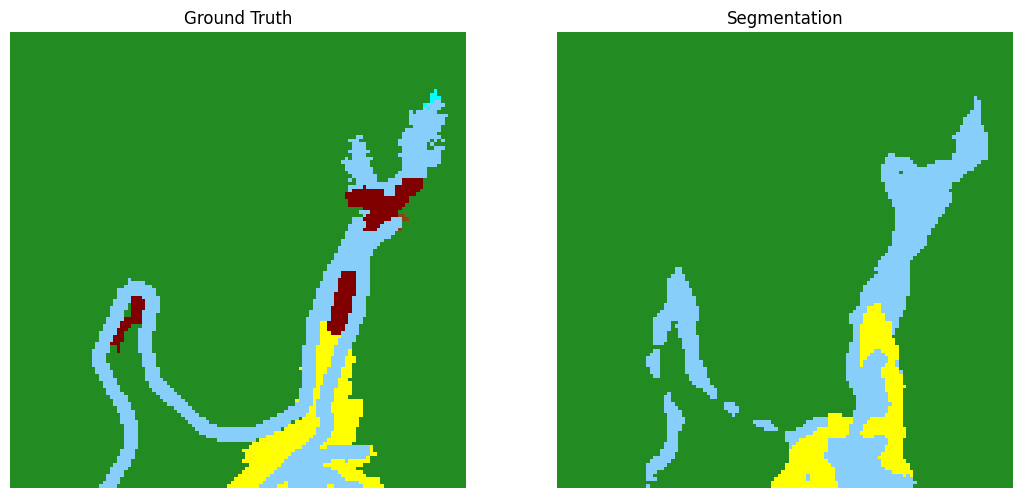

In [34]:
from visualization import predict_and_show
index = 9
predict_and_show(model_unet_timm_resnest14d_bw, val_dataset_bw, index)

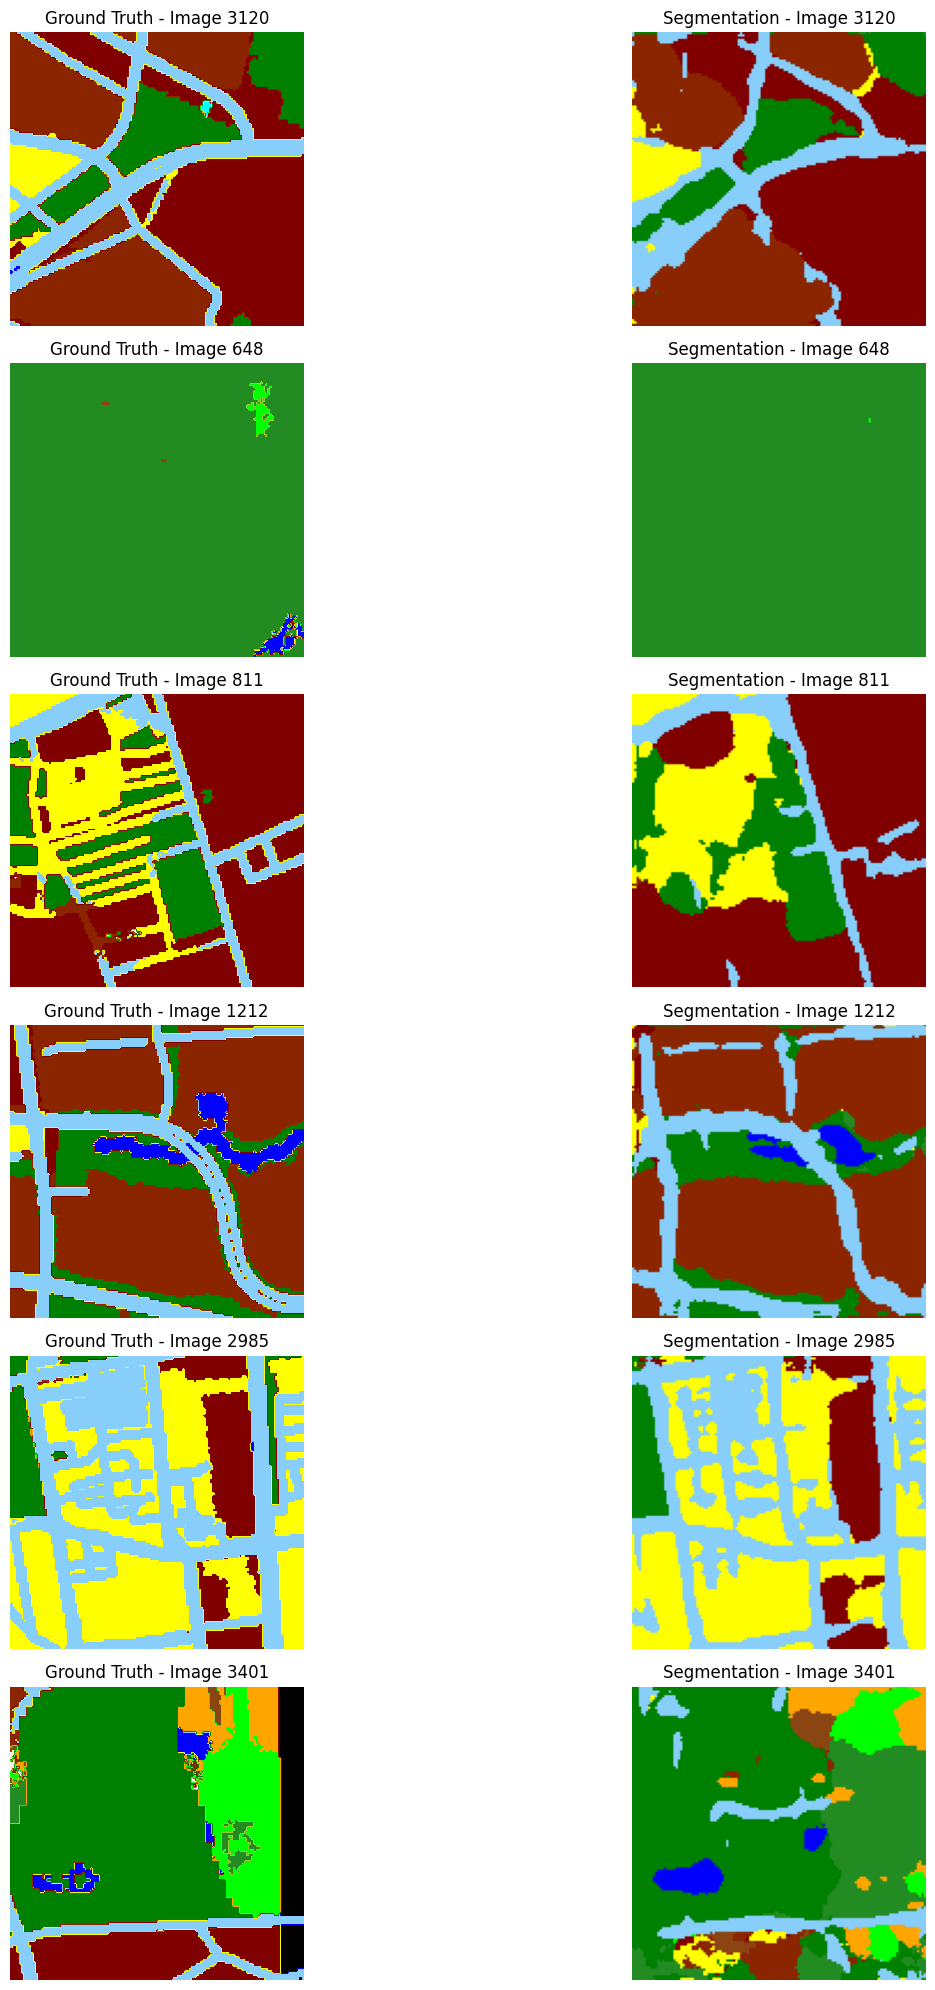

In [39]:
from visualization import predict_random_and_show
from visualization import predict_and_show
predict_random_and_show(model=model_unet_timm_resnest14d_bw, dataset=val_dataset_bw)

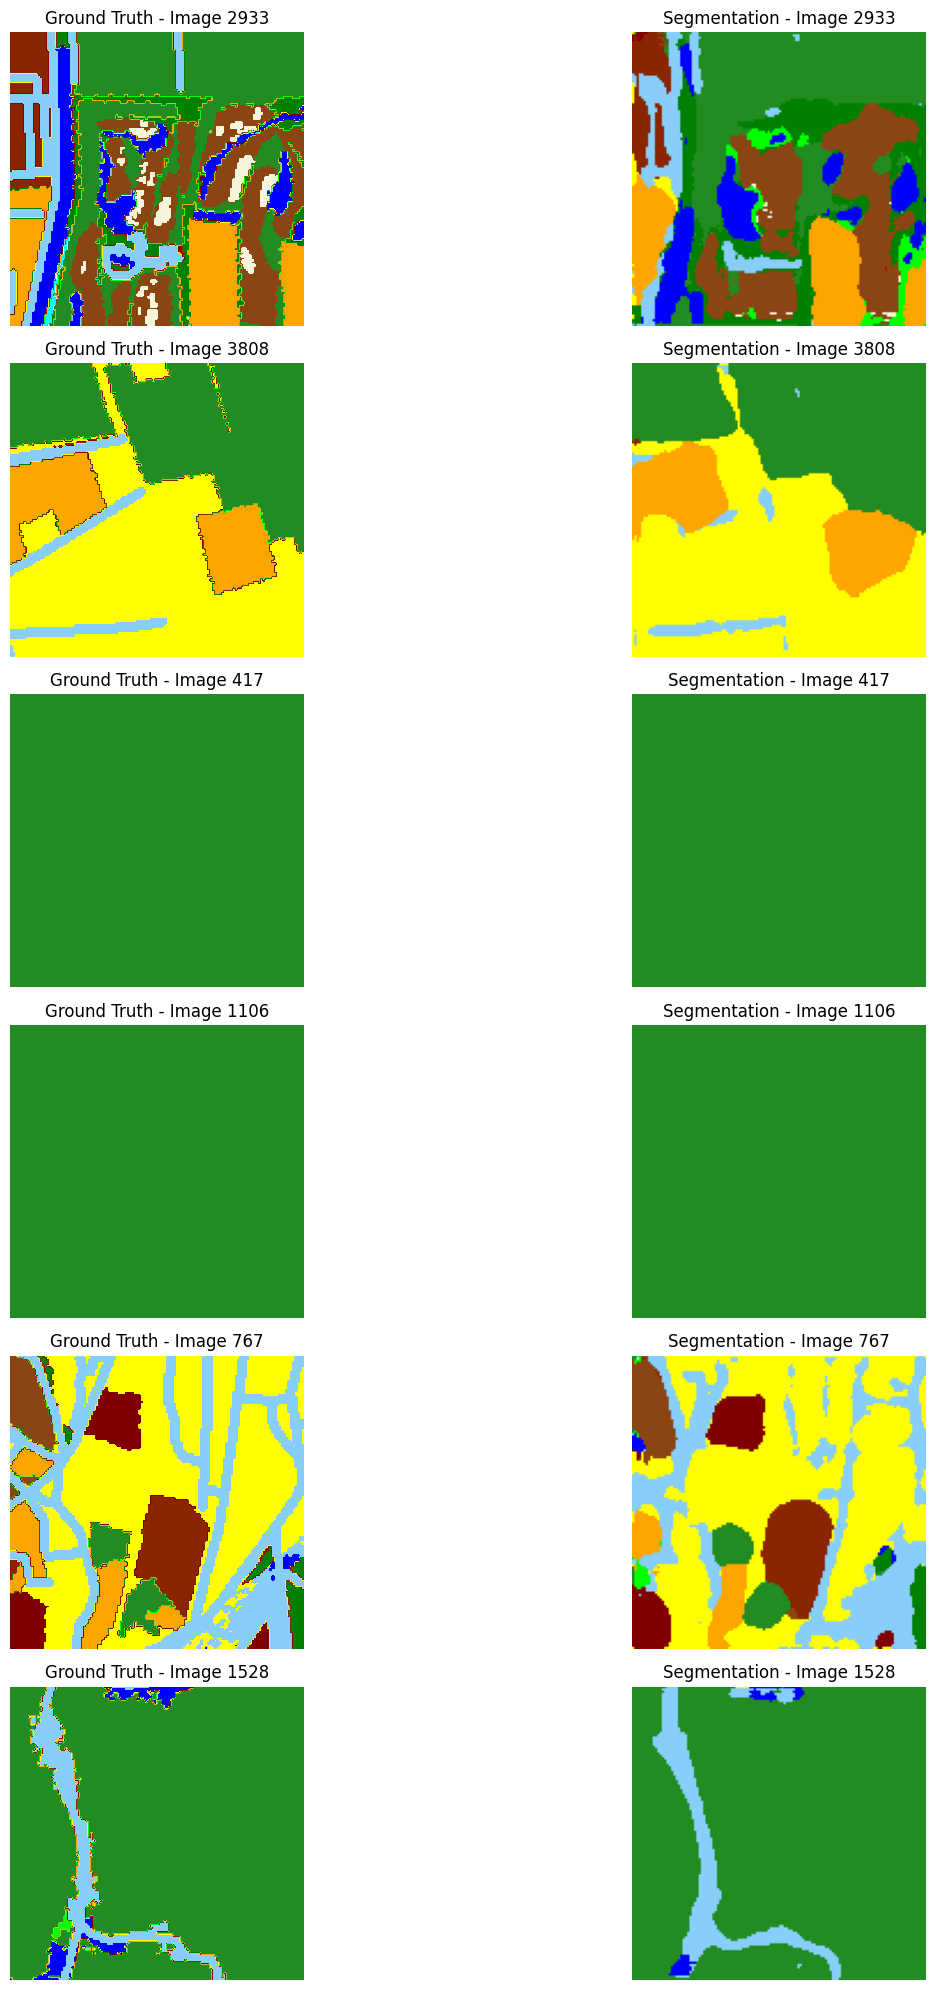

In [40]:
predict_random_and_show(model=model_unet_timm_resnest14d_bw, dataset=val_dataset_bw)

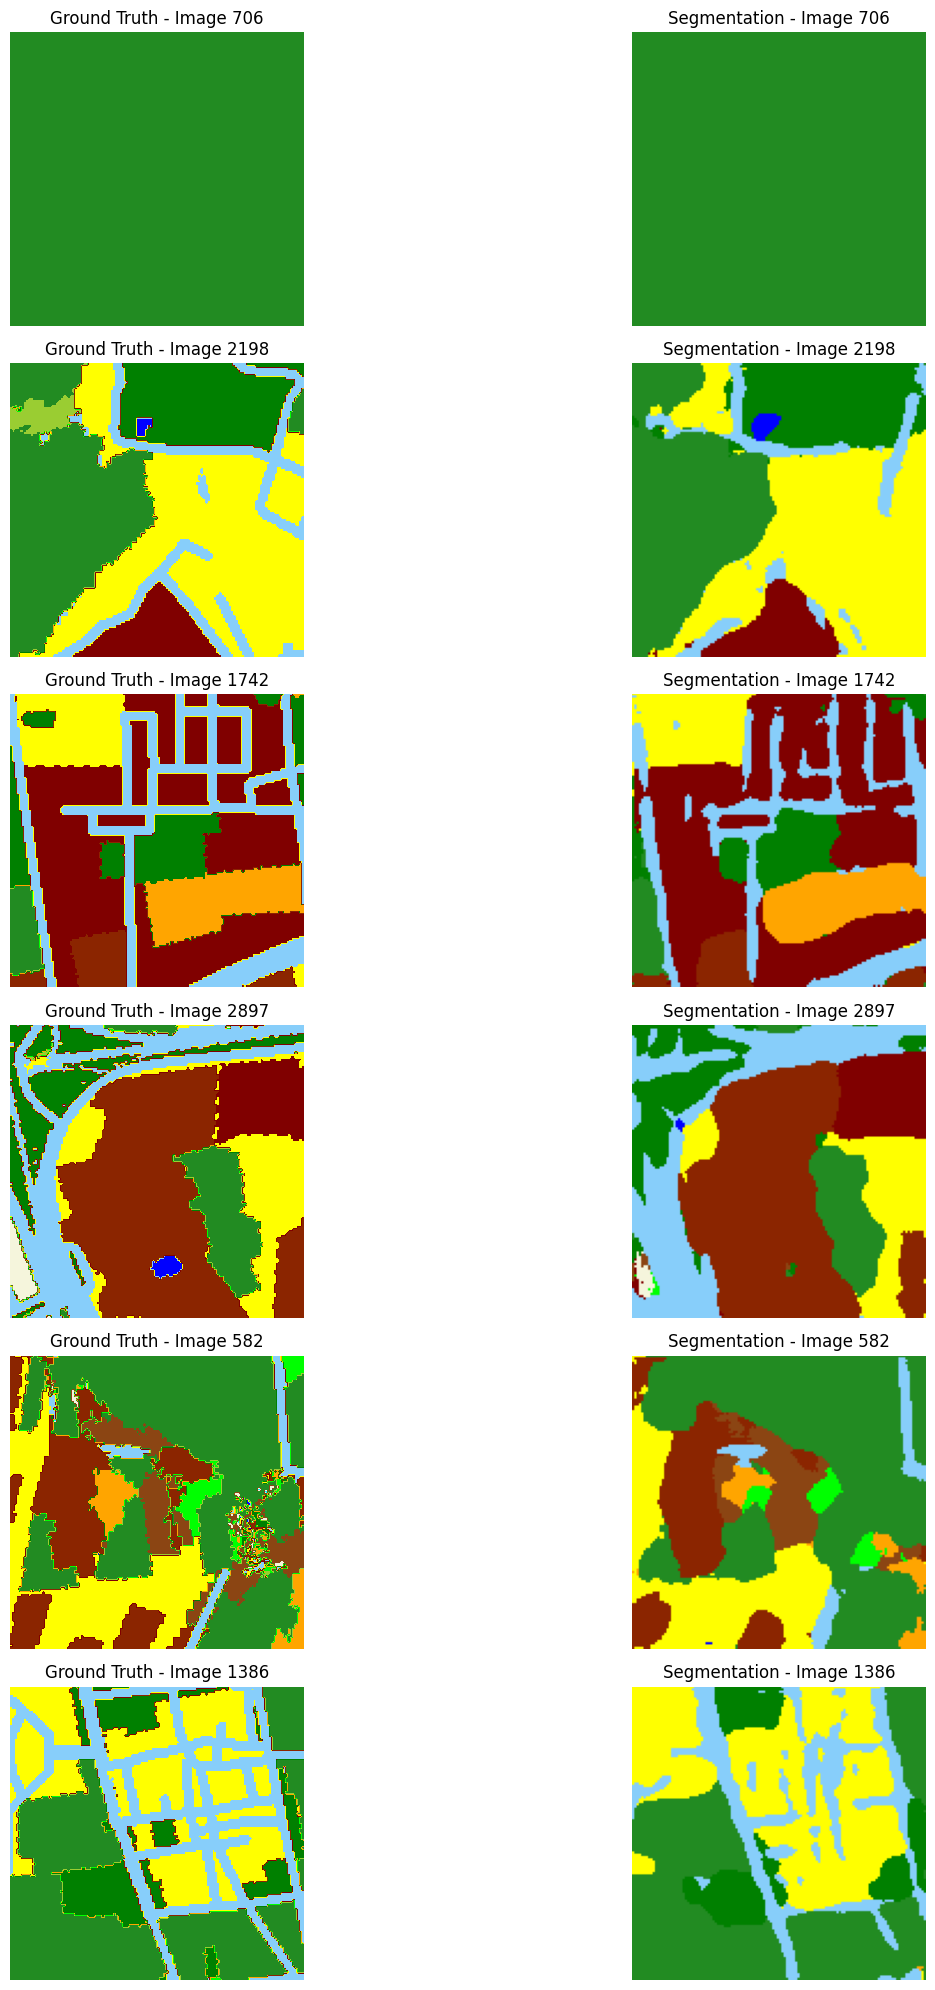

In [41]:
predict_random_and_show(model=model_unet_timm_resnest14d_bw, dataset=val_dataset_bw)